<a name="top"> <h1>2.8. XGBoost Model</h1> <a>

<p>Payments Fraud Practice<br />
<strong>Aprendizaje Autom&aacute;tico</strong><br />
<strong>Master Universitario en Ciencia de Datos</strong></p>

<p>&nbsp;</p>

<p style="text-align:right">Antonio Nogués Podadera (<em>antonio.nogues@cunef.edu</em>)</p>
<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>

<hr style="border:1px solid gray">

[0. Introducción](#introduccion) 


[1. Importación de librerias y funciones](#librerias) 


[2. Carga de datos](#datos) 

[3. Creación del modelo](#creacion) 

   
[4. Optimización del modelo](#optimizacion) 

   
[5. Predicción del modelo](#prediccion)

[6. Evaluación de las métricas del modelo](#metricas)

   - Matriz de confusión
   - Métricas: Accuracy, Recall, Precision, F1 y F2 score
   - Curva ROC

<hr style="border:1px solid gray">

# <a name="introduccion"> 0. Introducción <a> 


En este documento, nos centraremos en la creación de un **Modelo XGBoost**.


XGBoost es la abreviatura de las palabras inglesas "extreme gradient boosting" (refuerzo de gradientes extremo). Este método se basa en árboles de decisión y supone una mejora sobre otros métodos. Funciona bien con datasets grandes y complejos al utilizar varios métodos de optimización.

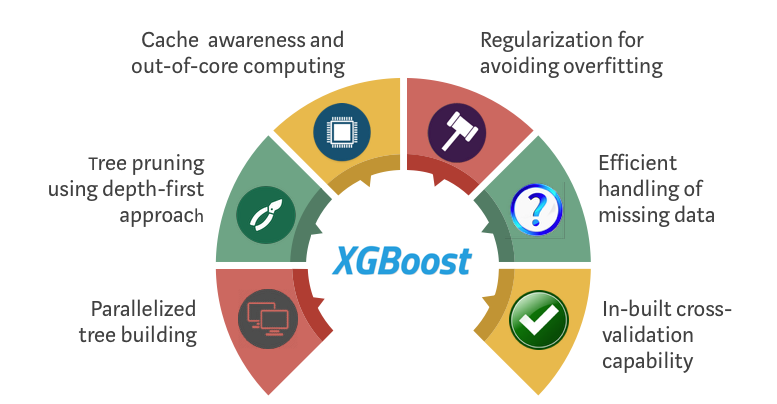

Una vez creado el modelo, procederemos a optimizarlo con los valores de train y predecir los valores de validación.


# <a name="librerias"> 1. Importación de librerias y funciones <a> 


Importamos las librerias necesarias para la creación y optimización del modelo XGBoost:

In [17]:
# Import basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Import sklearn metrics

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, fbeta_score
from sklearn.metrics import plot_confusion_matrix
import scikitplot as skplt
from sklearn.metrics import precision_recall_curve

# Import sklearn models and pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier



Importamos las funciones a utilizar:

In [2]:
from aux_functions import load_model, save_model

Cargamos el pickle de preprocesado, para su posterior uso:

In [3]:
#Load the preprocessor

preprocessor = load_model('../models/preprocessor.pickle')

# <a name="datos"> 2. Carga de datos <a> 

En primer lugar procederemos a cargar los datos de train y validación que insertaremos dentro del modelo para su optimización y predicción.

In [15]:
# Load the train dataset separated by other variables and target. Taking into account that the first column is the index.

x_train = pd.read_csv("../data/processed/x_train.csv",index_col=0 )
y_train = pd.read_csv("../data/processed/y_train.csv",index_col=0 )

# Load the validation dataset separated by other variables and target. Taking into account that the first column is the index.

x_val = pd.read_csv("../data/processed/x_val.csv",index_col=0 )
y_val = pd.read_csv("../data/processed/y_val.csv",index_col=0 )

# <a name="creacion"> 3. Creación del modelo <a> 

Para la creación del modelo **XGBOOST**  utilizaremos el algoritmo _XGBClassifier_ de la libreria _XGBoost_.

Creamos un Pipeline que junte el preprocesado y el algoritmo _XGBClassifier_para ejecutarlo en el orden mencionado.

Para el algoritmo designaremos los parámetros por default, pero utilizaremos todo el procesador para agilizar el proceso. En el caso de que obtenga muy buen resultado, estudiaresmo como modificar los hiperparámetros para tratar de mejorarlo.

In [5]:
# Design the parameters.

n_jobs = -1
random_state = 12345

# Create a pipeline that applies a preprocess of the data and then the LogisticRegression model.

xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('clasificador', XGBClassifier(n_jobs=n_jobs, random_state=random_state)
    )
])


# <a name="optimizacion"> 4. Optimización del modelo <a> 

Optimizamos el modelo a través del pipeline creado anteriormente, para ello introduciremos los valores de train.

In [6]:
# Optimization of the xgboost_model with the train set: input and target data. 

xgb_model.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknow',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['type', 'gender', 'device',
                                                   'zone', 'security_alert',
                                                   'nameDest', 'nameOrig',
                                                   'nameDest']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['step...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=12345, ...))])

Una vez optimizado el modelo XGB, con el set de train, procedemos a guardarlo en un pickle para que no se tenga que volver a computarlo en un futuro, por si quisieramos usarlo.

In [7]:
# Save the backup of the XGB optimziation as a pickle file.

save_model(xgb_model,'../models/xgb_model.pickle')

**Para evitar optimizar de nuevo el modelo, ejecutar a partir de la celda que aparece a continuación.**

In [8]:
# Load the XGB model already fitted in /models.

xgb_model = load_model('../models/xgb_model.pickle')


# <a name="prediccion"> 5. Predicción del modelo <a> 

Una vez realizada la optimización del modelo XGB, procederemos a predecir el set de validación, sus valores y probabilidades. Para posteriormente obtener las métricas y observar como se comporta el modelo y su score.

In [9]:
# Predict the target value of the validation set.

predictions = xgb_model.predict(x_val)

# Predict the probabilities of the target value for the validation set.

predict_probabilities = xgb_model.predict_proba(x_val)

# <a name="metricas"> 6. Evaluación de las métricas del modelo <a> 

En este aparatado procederemos a análizar las métricas obtenidas. En el caso de que se quiera consultar la definición de cada una de ellas, se pueden encontrar en el documento `02_DummyModel`.

### 6.1. Matriz de confusión

Confusion matrix, without normalization
[[196394      0]
 [    39    175]]
Normalized confusion matrix
[[1.         0.        ]
 [0.18224299 0.81775701]]


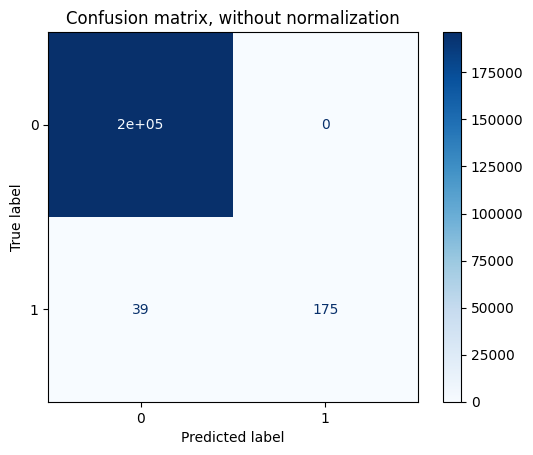

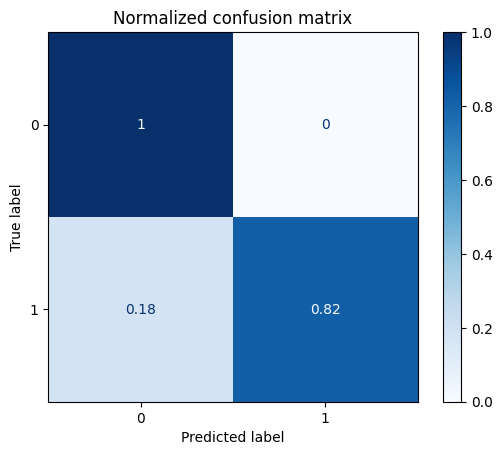

In [10]:
# List with the titles and parameters

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

# Plot the confusion matrix

for title, normalize in titles_options:
    disp = plot_confusion_matrix(xgb_model, x_val, y_val,
                                 # display_labels=ytest,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

La matriz de confusión nos deja ver que el modelo se comporta muy bien puesto que **es capaz de predecir un 82% de la clase 1 que es el fraude**. A continuación se van a analizar las diferentes métricas. 

### 6.2. Métricas: Accuracy, Recall, Precision, F1 score

In [10]:
# Print the general metrics.

print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    196394
           1       1.00      0.82      0.90       214

    accuracy                           1.00    196608
   macro avg       1.00      0.91      0.95    196608
weighted avg       1.00      1.00      1.00    196608



In [12]:
# Print the F2 score.

print('F2 score is ' +str(fbeta_score(y_val, predictions, average='binary', beta=2)))

# Model Accuracy

print("Accuracy:",metrics.accuracy_score(y_val, predictions))

F2 score is 0.848690591658584
Accuracy: 0.9998016357421875


Como ya comentamos en el documento `02_DummyModel`, nuestro dataset se caracteriza por tener un desbalanceo muy grande, es por ello que el análisis de las métricas de accuracy y precisión siempre van a ser muy elevadas, sin embargo, no reflejan la realidad predictora de nuestro modelo. Por lo que nos centraremos principalmente en las métricas F2-score y AUC .

- El modelo nos calcula un **Recall de 0.91**, valor alto,  lo que significa que el modelo llega a detectar correctamente aquellas transacciones que son fraude o no.

- El modelo nos calcula un **F2 score de 0.84**, el valor más alto de todos los modelos que hemos estudiado, lo cual es una gran opción a ser escogido para el proceso de predicción sobre el set de test.

### 6.3. Curva ROC

Para evaluar nuestro modelo, la representaremos graficamente para deducir que tan bueno es el modelo.

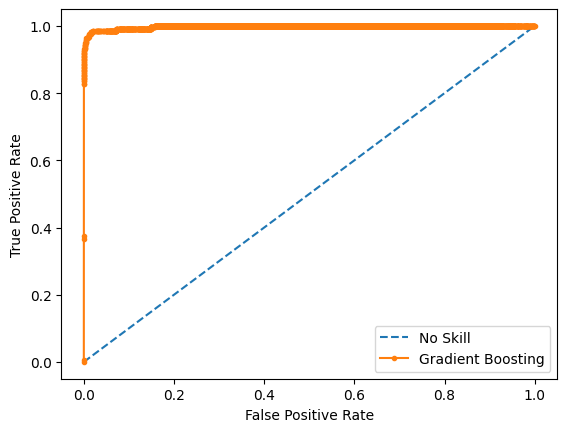

The Compute Area Under the Receiver Operating Characteristic is 0.9977765228566379


In [14]:
# Keep probabilities for the positive outcome only
yhat = predict_probabilities[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_val, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Gradient Boosting')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# Show the plot
plt.show()

# Display the ROC AUC.

print('The Compute Area Under the Receiver Operating Characteristic is '+ str(metrics.roc_auc_score(y_val,yhat)))

**Además de haber obtenido un gran score en la métrica F2, el AUC es extremadamente bueno, por lo que es un gran candidato para predecir el set de test.**.

[Ir arriba del documento](#top)